In [36]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import deeplay as dl  # same library you used for UNet2d

# 1. Device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Recreate the same Regressor + UNet template
unet = dl.UNet2d(
    in_channels=1, channels=[16, 32, 64, 128, 256], out_channels=1, skip=dl.Cat(),
)
regressor = dl.Regressor(
    model=unet,
    loss=torch.nn.MSELoss(),
    optimizer=dl.Adam(lr=1e-3),
).create().to(device)

# 2. Load the entire trained state
regressor.load_state_dict(torch.load("denoiser_model.pth", map_location=device))
regressor.eval()

# 3. The denoiser UNet is now at
denoiser_net = regressor.model

# 4. Prepare your noisy image
#    - replace 'path/to/your_noisy.png' with your file
test_path = 'reconstructed.png' # or any other path
img = Image.open(test_path).convert('L')  # 'L' for grayscale

to_tensor = transforms.ToTensor()
noisy = to_tensor(img).unsqueeze(0).to(device)

with torch.no_grad():
    out = denoiser_net(noisy).clamp(0,1)

# Back to PIL:
denoised = transforms.ToPILImage()(out.squeeze(0).cpu())

# Save or display:
import os
out_name = os.path.splitext(os.path.basename(test_path))[0] + '.png'
out_path = os.path.join('denois_result', out_name)
denoised.save(out_path)

C:\Users\alish\AppData\Local\Temp\ipykernel_3172\3037333517.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  regressor.load_state_dict(torch.load("denoiser_model.pth", m

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import deeplay as dl
import os
import random

# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Recreate the same Regressor + UNet template
unet = dl.UNet2d(
    in_channels=1, channels=[16, 32, 64, 128, 256], out_channels=1, skip=dl.Cat(),
)
regressor = dl.Regressor(
    model=unet,
    loss=torch.nn.MSELoss(),
    optimizer=dl.Adam(lr=1e-3),
).create().to(device)

# 2. Load the entire trained state
regressor.load_state_dict(torch.load("models\denoiser_model.pth", map_location=device))
regressor.eval()
denoiser_net = regressor.model

# 4. Prepare folder paths
test_folder = "results/jigsaw/reconstructed" # Change to your folder path
output_folder = 'results/denoiser'
os.makedirs(output_folder, exist_ok=True)

# 5. Get all image files in the folder
all_files = [f for f in os.listdir(test_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
sample_files = random.sample(all_files, min(100, len(all_files)))

to_tensor = transforms.ToTensor()

for fname in all_files:
    img_path = os.path.join(test_folder, fname)
    img = Image.open(img_path).convert('L')
    noisy = to_tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = denoiser_net(noisy).clamp(0,1)
    denoised = transforms.ToPILImage()(out.squeeze(0).cpu())
    out_name = os.path.splitext(fname)[0] + '_denoised.png'
    out_path = os.path.join(output_folder, out_name)

    denoised.save(out_path)


C:\Users\alish\AppData\Local\Temp\ipykernel_2164\3020187257.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  regressor.load_state_dict(torch.load("models\denoiser_model.

In [6]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def show_denoising_result(model, image_path, device=None):
    """
    model: PyTorch model (should be in eval mode)
    image_path: path to the noisy input image
    device: torch.device (optional)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Load and preprocess image
    img = Image.open(image_path).convert('L')
    to_tensor = transforms.ToTensor()
    noisy_tensor = to_tensor(img).unsqueeze(0).to(device)

    # Denoise
    with torch.no_grad():
        out = model(noisy_tensor).clamp(0, 1)
    denoised = out.squeeze(0).cpu().numpy()[0]

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Noisy Input')
    axs[0].axis('off')

    axs[1].imshow(denoised, cmap='gray')
    axs[1].set_title('Denoised Output')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

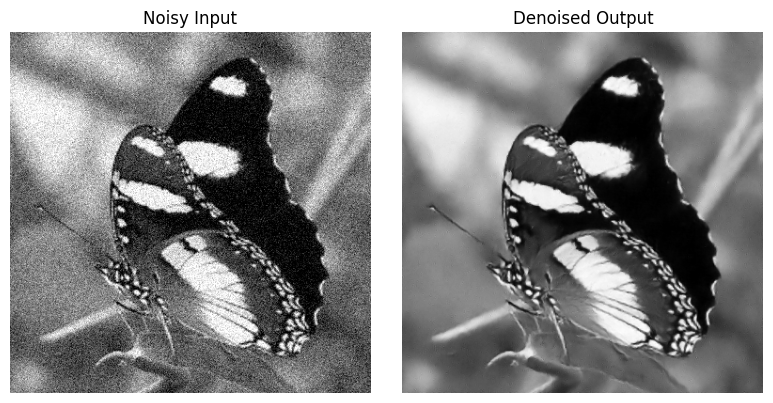

In [9]:
show_denoising_result(denoiser_net, "results/jigsaw/reconstructed/Image_1313_reconstructed.png", device=device)

In [12]:
import torch
from torchvision import transforms
from PIL import Image
import deeplay as dl
import os
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Paths
noisy_folder = "results/jigsaw/reconstructed"      # Folder with noisy images
gt_folder = "dataset/test"          # Folder with ground truth images
model_path = "models/denoiser_model.pth"           # Path to saved model

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model setup (must match training)
unet = dl.UNet2d(
    in_channels=1, channels=[16, 32, 64, 128, 256], out_channels=1, skip=dl.Cat(),
)
regressor = dl.Regressor(
    model=unet,
    loss=torch.nn.MSELoss(),
    optimizer=dl.Adam(lr=1e-3),
).create().to(device)
regressor.load_state_dict(torch.load(model_path, map_location=device))
regressor.eval()
denoiser_net = regressor.model

# Image transform
to_tensor = transforms.ToTensor()

# Evaluation
mse_list, psnr_list, ssim_list, orig_list = [], [], [], []
all_files = [f for f in os.listdir(noisy_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

# ...existing code...

for fname in all_files:
    noisy_path = os.path.join(noisy_folder, fname)
    # Remove '_reconstructed' and change extension to '.jpg'
    base = fname.replace('_reconstructed', '')
    gt_name = os.path.splitext(base)[0] + '.jpg'
    gt_path = os.path.join(gt_folder, gt_name)
    if not os.path.exists(gt_path):
        print(f"Ground truth not found for {fname}, skipping.")
        continue

    # Load images
    noisy_img = Image.open(noisy_path).convert('L')
    gt_img = Image.open(gt_path).convert('L')

    # Resize ground truth to match noisy image size
    if noisy_img.size != gt_img.size:
        gt_img = gt_img.resize(noisy_img.size, Image.BICUBIC)

    # To tensor
    noisy_tensor = to_tensor(noisy_img).unsqueeze(0).to(device)
    gt_tensor = to_tensor(gt_img).numpy()[0]
    noisy_arr = to_tensor(noisy_img).numpy()[0]

# ...existing code...

    # Compute original PSNR (noisy vs ground truth)
    orig_psnr = psnr(gt_tensor, noisy_arr, data_range=1)

    # Denoise
    with torch.no_grad():
        out = denoiser_net(noisy_tensor).clamp(0,1)
    denoised = out.squeeze(0).cpu().numpy()[0]

    # Metrics
    mse = np.mean((denoised - gt_tensor) ** 2)
    mse_list.append(mse)
    psnr_list.append(psnr(gt_tensor, denoised, data_range=1))
    ssim_list.append(ssim(gt_tensor, denoised, data_range=1))
    orig_list.append(orig_psnr)  # <-- Fix here

print(f"Mean Original PSNR: {np.mean(orig_list):.2f} dB")
print(f"Mean MSE: {np.mean(mse_list):.6f}")
print(f"Mean PSNR: {np.mean(psnr_list):.2f} dB")
print(f"Mean SSIM: {np.mean(ssim_list):.4f}")

C:\Users\alish\AppData\Local\Temp\ipykernel_31180\353703202.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  regressor.load_state_dict(torch.load(model_path, map_locatio

Mean Original PSNR: 17.89 dB
Mean MSE: 0.014293
Mean PSNR: 24.65 dB
Mean SSIM: 0.7723


In [13]:
print(f"Mean Original PSNR (Noisy vs GT): {np.mean(orig_list):.2f} dB")
print(f"Mean Denoised PSNR (Denoised vs GT): {np.mean(psnr_list):.2f} dB")
print(f"Mean MSE: {np.mean(mse_list):.6f}")
print(f"Mean SSIM: {np.mean(ssim_list):.4f}")

Mean Original PSNR (Noisy vs GT): 17.89 dB
Mean Denoised PSNR (Denoised vs GT): 24.65 dB
Mean MSE: 0.014293
Mean SSIM: 0.7723
